In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json
import data
import tqdm
import skimage.measure


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
desc = json.load(open('data/track_configuration.json'))
img = np.zeros((3100, 4000), dtype=int)
for shape in desc['shapes']:
    lb, rt = data.get_bounding_box(shape)
    lb[0] = max(lb[0], 0)
    lb[1] = max(lb[1], 0)
    rt[0] = min(rt[0], img.shape[1] - 1)
    rt[1] = min(rt[1], img.shape[0] - 1)
    for i in range(int(lb[0] - 1), int(rt[0] + 1)):
        for j in range(int(lb[1] - 1), int(rt[1] + 1)):
            if data.detect(i, j, shape):
                img[j][i] = 1
                
while img.shape[0] > 1000:
    img = skimage.measure.block_reduce(img, (2,2), np.max)

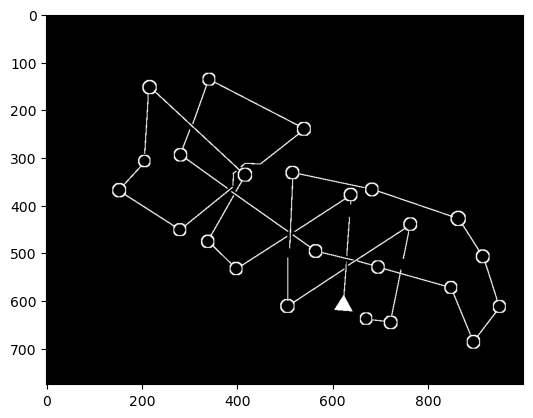

In [3]:
plt.imshow(img, cmap='gray')

In [4]:
def circle_mask(c, shape):
    mask = np.zeros((shape[0],shape[1],1), np.uint8)
    cv2.circle(mask,(c[1],c[0]),c[2],1,10)
    return mask

def check(c, img, visualize=False):
    mask = circle_mask(c, img.shape)    
    res = cv2.bitwise_xor(img, mask)
    a = int(np.sqrt(2)/2 * c[2]) - 1
    res_square = res[c[0]-a:c[0] + a, c[1] - a:c[1]+a]
    if visualize:
        plt.imshow(img[c[0] - c[2]: c[0] + c[2], c[1] - c[2]:c[1] + c[2]])
        plt.show()
    return res_square.sum() < 0.02 * 255 * (4 * a * a)

def check_circle_cv_kernel(c, img, visualize=False, print_score=False):
    kernel = np.float32(cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2 * c[2] + 1, 2 * c[2] + 1)))
    kernel[3:-3, 3:-3] -= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2 * c[2] - 5, 2 * c[2] - 5))
    kernel[6:-6, 6:-6] -= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2 * c[2] - 11, 2 * c[2] - 11))
    res_square = img[c[0]-c[2]:c[0] + c[2] + 1, c[1] - c[2]:c[1]+c[2] + 1] / 255
    if visualize:
        ax1 = plt.subplot(1, 2, 1)
        ax2 = plt.subplot(1, 2, 2)
        ax1.imshow(res_square)
        ax2.imshow((kernel + 1) / 2)
        plt.show()

    score = np.multiply(kernel, res_square).sum()
    threshold = 0.3 * np.absolute(kernel).sum()
    if print_score:
        print(score, threshold)
    return score > threshold

def hough_circle_fixed_radius(img, r, visualize=False):
    img8 = np.uint8(img * 255)
    res = np.zeros_like(img)
    n, m = img.shape
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
    course = cv2.dilate(img8, kernel)
    plt.imshow(course)
    plt.show()
    
    for i in tqdm.tqdm(range(0, n)):
        for j in range(0, m):
            if course[i,j] == 255:
                res += circle_mask((i,j,r), course.shape).reshape((n, m))
    threshold = 0.8 * res.max()
    res[res < threshold] = 0
#     print(res.max())
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8,8))
    course = cv2.erode(course, kernel)
    circles = []
    for i in tqdm.tqdm(range(0, n)):
        for j in range(0, m):
            if res[i,j] >= threshold and check_circle_cv_kernel((i, j, r+3), course,visualize=False, print_score=False):
                circles.append(np.array([i, j]))
    circles_filtered = []
    for circle in circles:
        duplicate = False
        for filtered_circle in circles_filtered:
            if np.linalg.norm(circle - filtered_circle) < r * 2:
                duplicate = True
                break
        if not duplicate:
            circles_filtered.append(circle)
    if visualize:
        n_res = np.zeros(res.shape)
        for circle in circles_filtered:
            n_res += circle_mask((circle[0],circle[1],r), course.shape).reshape((n, m))
        plt.imshow(n_res, cmap='gray')
        plt.show()
    return circles_filtered


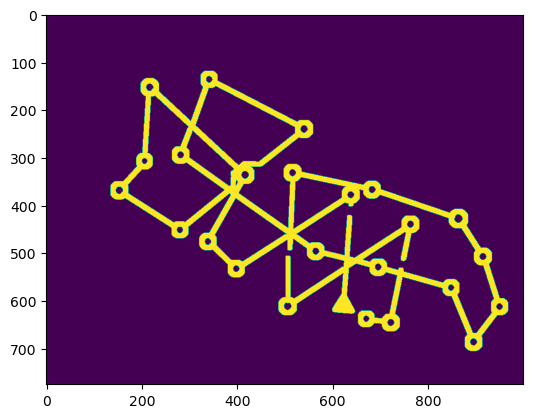

100%|███████████████████████████████████████| 775/775 [00:00<00:00, 1409.27it/s]


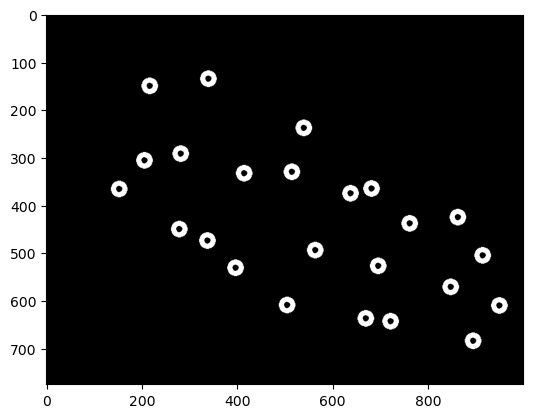

[array([135, 340]), array([150, 217]), array([238, 540]), array([292, 282]), array([306, 206]), array([330, 515]), array([333, 415]), array([365, 682]), array([366, 153]), array([375, 638]), array([425, 863]), array([438, 762]), array([450, 279]), array([474, 338]), array([494, 564]), array([505, 915]), array([527, 696]), array([531, 397]), array([571, 848]), array([609, 505]), array([610, 950]), array([637, 670]), array([643, 722]), array([684, 895])]


In [5]:
circles = hough_circle_fixed_radius(img, 12, visualize=True)

print(circles)

In [49]:
import heapq

def get_angle(x, y, nx, ny, prex, prey):
    if prex[x,y] == -1:
        return 0
    px = prex[x, y]
    py = prey[x, y]
    v1 = [nx - x, ny - y]
    v2 = [x - px, y - py]
    u1 = v1 / np.linalg.norm(v1)
    u2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(u1, u2)
    return np.arccos(dot_product)


def penalty(c1, c2, course):
    dist = np.float64(np.full_like(course, 10.0 ** 10))
    prex = np.full_like(course, -1)
    prey = np.full_like(course, -1)
    
    approx_metric = abs(c2[0] - c1[0]) + abs(c2[1] - c1[1])
    coefficient = 2
    if approx_metric > 600:
        coefficient = 1.6
    if approx_metric > 1000:
        coefficient = 1.3
    
    q = []
    for i in range(-12, 13):
        for j in range(-12, 13): 
            x = c1[0] + i
            y = c1[1] + j
            dist[x, y] = 0
            heapq.heappush(q, (0, (x, y)))
    while len(q) > 0:
        d, v = heapq.heappop(q)
        x, y = v[0], v[1]
        if x == c2[0] and y == c2[1]:
            break
        already_done_metric = abs(c1[0] - x) + abs(c1[1] - y)
        approx_leftover_metric = abs(c2[0] - x) + abs(c2[1] - y)
        
        if already_done_metric != 0:
            approx_dist = approx_metric / already_done_metric * d

            if approx_dist > approx_metric * 2:
                continue
        
        local_area_size = 3
        if approx_leftover_metric < 20:
            local_area_size = 2
        if approx_leftover_metric < 5:
            local_area_size = 1
        for dx in [-local_area_size, 0, local_area_size]:
            dy_set = [-local_area_size, 0, local_area_size]
            for dy in dy_set:
                if dx == 0 and dy == 0:
                    continue
                nx = x + dx
                ny = y + dy
                if nx < 0 or ny < 0 or nx >= course.shape[0] or ny >= course.shape[1]:
                    continue
                n_cost = dist[x, y] + 1 + local_area_size ** 2 * (1 - course[nx, ny]) + get_angle(x, y, nx, ny, prex, prey)
                if dist[nx,ny] > n_cost:
#                     if dist[nx,ny] == 10.0 ** 10:
                    heapq.heappush(q, (n_cost, (nx, ny)))
                    dist[nx, ny] = n_cost
                    prex[nx, ny] = x
                    prey[nx, ny] = y
    return dist[c2[0], c2[1]], prex, prey

In [50]:
def draw_path(course, x, y, prex, prey, addx, addy):
    res = np.uint8(course * 255)
    while prex[x,y] != -1:
        nx = prex[x,y]
        ny = prey[x,y]
        cv2.line(res, (y + addy, x + addx), (ny + addy, nx + addx), 255, 10)
        x = nx
        y = ny
    plt.imshow(res)
    plt.show()

In [51]:
penalties_cache = {}
def calculate_penalty(c1_idx, c2_idx, circles, img, visualize=False):
    key = str(c1_idx) + ';' + str(c2_idx) + ';' + str(hash(len(circles)))
    if key in penalties_cache:
        return penalties_cache[key]
    minx = min(circles[c1_idx][0], circles[c2_idx][0]) - 50
    maxx = max(circles[c1_idx][0], circles[c2_idx][0]) + 50
    miny = min(circles[c1_idx][1], circles[c2_idx][1]) - 50
    maxy = max(circles[c1_idx][1], circles[c2_idx][1]) + 50
    dist, prex, prey = penalty([circles[c1_idx][0] - minx, circles[c1_idx][1] - miny], [circles[c2_idx][0] - minx, circles[c2_idx][1] - miny], img[minx:maxx+1, miny:maxy+1])
    if visualize:
        draw_path(img, circles[c2_idx][0] - minx, circles[c2_idx][1] - miny, prex, prey, minx, miny)
    penalties_cache[key] = dist
    return dist

/tmp/ipykernel_6519/1987998820.py:13: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(dot_product)


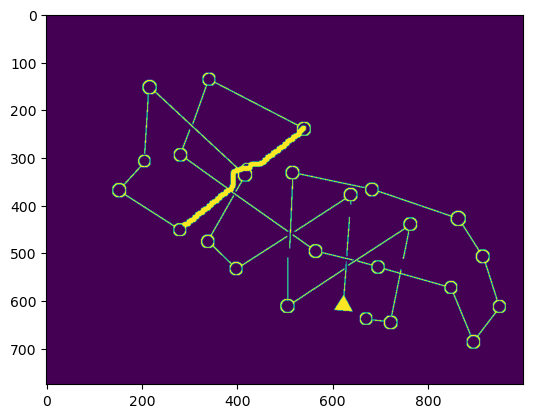

433.46680721995307

In [52]:
calculate_penalty(12, 2, circles, img, visualize=True)

/tmp/ipykernel_6519/1987998820.py:13: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(dot_product)


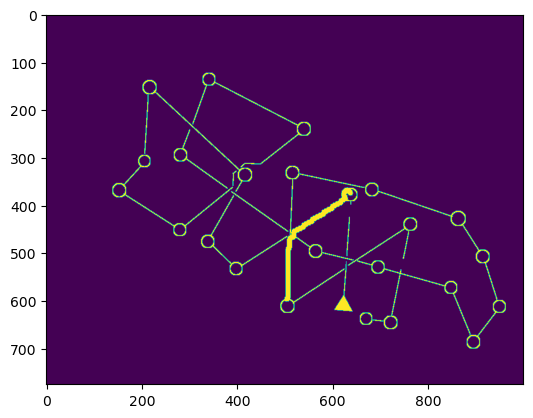

360.90928805153857

In [53]:
calculate_penalty(19, 9, circles, img, visualize=True)

/tmp/ipykernel_6519/1987998820.py:13: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(dot_product)


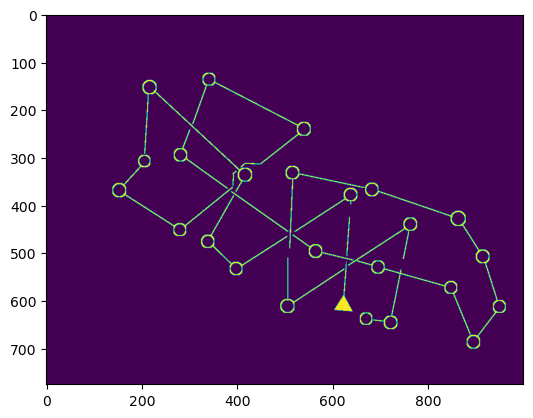

10000000000.0

In [54]:
calculate_penalty(6, 5, circles, img, visualize=True)

In [55]:
def calculate_dist_matrix(img, circles):
    res = []
    n = len(circles)
    for i in tqdm.tqdm(range(n)):
        res.append([])
        for j in range(n):
            if i == j:
                res[-1].append(0)
                continue
            if i < j:
                res[-1].append(calculate_penalty(i, j, circles, img))
            else:
                res[-1].append(res[j][i])
    return res

/tmp/ipykernel_6519/1987998820.py:13: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(dot_product)


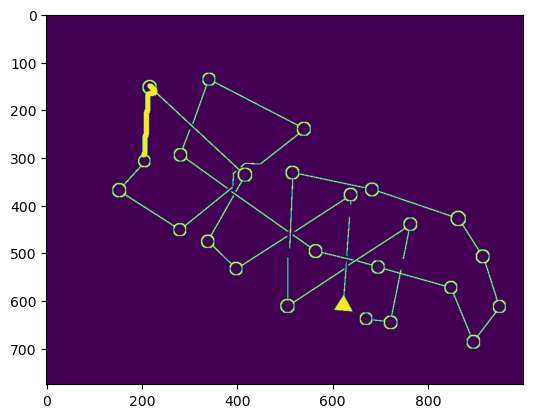

149.63937986059216

In [58]:
calculate_penalty(4, 1, circles, img, visualize=True)

/tmp/ipykernel_6519/1987998820.py:13: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(dot_product)


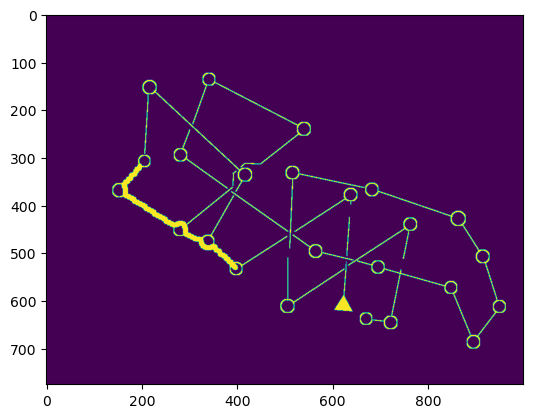

461.6083998946163

In [57]:
calculate_penalty(4, 17, circles, img, visualize=True)

In [59]:
penalties_cache = {}

subsample_circles = [circles[9], circles[17], circles[13], circles[1], circles[6], circles[4]]

In [63]:
dist_matrix_full = calculate_dist_matrix(img, circles)

  0%|                                                    | 0/24 [00:00<?, ?it/s]/tmp/ipykernel_6519/1987998820.py:13: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(dot_product)
100%|████████████████████████████████████████| 24/24 [1:27:28<00:00, 218.69s/it]


In [71]:
dist_matrix_full = np.array(dist_matrix_full)
dist_matrix_full[:,0],dist_matrix_full[:,9] = dist_matrix_full[:,9],dist_matrix_full[:,0]
dist_matrix_full[0,:],dist_matrix_full[9,:] = dist_matrix_full[9,:],dist_matrix_full[0,:]
circles[0], circles[9] = circles[9], circles[0]

In [72]:
from scipy.optimize import linear_sum_assignment

from python_tsp.heuristics import solve_tsp_simulated_annealing
from python_tsp.exact import solve_tsp_dynamic_programming


def draw_permutation(course, circles, permutation):
    res = np.zeros((course.shape[0],course.shape[1],1), np.uint8)
    for circle in circles:
        cv2.circle(res, (circle[1],circle[0]),12,255,10)
    for i in range(len(permutation) - 1):
        cv2.line(res, (circles[permutation[i]][1], circles[permutation[i]][0]), ((circles[permutation[i+1]][1], circles[permutation[i+1]][0])), 255, 10)

    plt.imshow(res)
    plt.show()

def get_best_permutation(circles, d, img, visualize=False):
    n = len(circles)
    matrix = np.array(d)
    matrix[:, 0] = 0
#     edges = []
#     for i in range(n):
#         for j in range(n):
#             if i != j:
#                 matrix[i][j] = d[i][j]
#             else:
#                 matrix[i][j] = 10 ** 10
#         matrix[n][i] = 0
#         matrix[i][n] = 0
#             if i != j:
#                 edges.append((i, n + 1 + j, d[i][j]))
#         edges.append((i, n, 0))
#     G = nx.Graph()
#     G.add_weighted_edges_from(edges)
#     matching = nx.min_weight_matching(G)
#     prev = {}
#     for elem in matching:
#         if elem[0] > elem[1]:
#             elem = (elem[1], elem[0])
#         prev[elem[1] - (n + 1)] = elem[0]
#     print(prev)
#     res = []
#     cur = -1
#     while cur in prev:
#         res.append(prev[cur])
#         cur = prev[cur]
#     res = res[::-1]
    print(matrix)
#     print(linear_sum_assignment(matrix))
#     assignment = linear_sum_assignment(matrix)[1]
#     res = []
#     cur = 6
#     while assignment[cur] != 6:
#         res.append(assignment[cur])
#         cur = assignment[cur]
#     print(res)
    res, distance = solve_tsp_simulated_annealing(matrix)
    print(res, distance)
#     alternative = [0, 4, 3, 5, 2, 1]
#     s = 0
#     for i in range(n-1):
#         s += matrix[alternative[i]][alternative[i+1]]
#     print(alternative, s)
    if visualize:
        draw_permutation(img, circles, res)
#     return res
    return 
# subsample_circles = [circles[13], circles[17], circles[9], circles[1], circles[6], circles[4]]

[[0.00000000e+00 7.34526539e+02 1.00000000e+10 5.80398224e+02
  1.00000000e+10 1.31707963e+02 3.64415927e+02 5.17123891e+01
  1.00000000e+10 0.00000000e+00 1.98626103e+02 1.93918139e+02
  5.98595123e+02 4.65320789e+02 2.61493362e+02 2.90119464e+02
  2.63634954e+02 3.81685835e+02 4.13767695e+02 3.52196899e+02
  3.87325215e+02 4.02707963e+02 4.14055306e+02 4.88960169e+02]
 [0.00000000e+00 0.00000000e+00 5.19745567e+02 2.29411501e+02
  1.41639380e+02 5.88174770e+02 3.61896011e+02 7.48380521e+02
  2.33986723e+02 7.34526539e+02 9.06723438e+02 9.16161493e+02
  4.50046455e+02 5.77243354e+02 6.90654855e+02 9.89572994e+02
  8.12143791e+02 6.36522114e+02 9.46422550e+02 7.79659280e+02
  1.08677874e+03 9.34787596e+02 9.57134939e+02 1.06955087e+03]
 [0.00000000e+00 5.19745567e+02 0.00000000e+00 4.49462382e+02
  6.10896011e+02 2.13566371e+02 1.87484510e+02 1.00000000e+10
  6.73101761e+02 1.00000000e+10 1.00000000e+10 1.00000000e+10
  4.32037604e+02 3.95754418e+02 4.07772121e+02 9.62663706e+02
  5.29

[0, 9, 7, 11, 10, 15, 20, 23, 18, 21, 22, 16, 14, 19, 5, 2, 6, 3, 1, 4, 8, 12, 13, 17] 3188.7632409952244


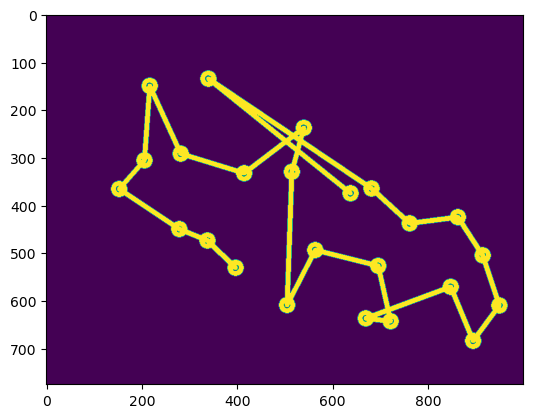

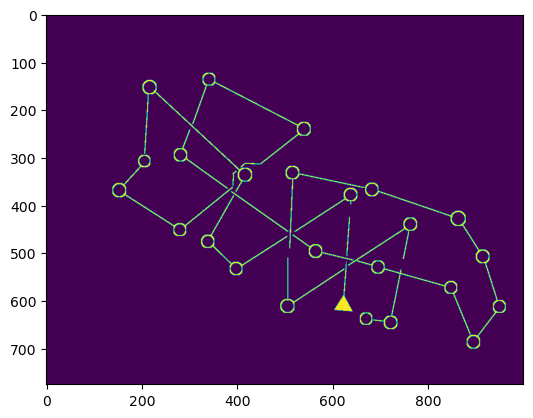

In [73]:
get_best_permutation(circles, dist_matrix_full, img, visualize=True)
plt.imshow(img)